In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [101]:
sns.set_style('darkgrid')

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [20]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [3]:
preddir = '/home/rasp/data/myWeatherBench/predictions/'
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [4]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [37]:
valid = valid.isel(time=slice(0, None, 12))

In [59]:
rmse_baseline = read_pickle('./rmse.pkl')
rmse_weyn = xr.open_dataset('./weyn_rmse.nc')

## get scores for direct predictions

In [38]:
def get_direct_scores_from_nc(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS):
    scores = []
    for exp_id in tqdm(exp_ids):
        fn = glob(f'{preddir}{exp_id}*.nc')[0]
        preds = xr.open_dataset(fn)
        scores.append(
            func(
                preds, 
                valid,
                mean_dims
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [39]:
rmse_direct = get_direct_scores_from_nc([129, 130, 131, 132], [6, 24, 72, 120])

In [51]:
def get_direct_train_scores(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS, years=['2014', '2015']):
    scores = []
    for exp_id in tqdm(exp_ids):
        fn = glob(f'../nn_configs/B/{exp_id}*.yml')[0]
        args = load_args(fn)
        model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})

        mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
        std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
        args['ext_mean'] = mean
        args['ext_std'] = std
        args['train_years'] = years
        dg_train, dg_valid, dg_test = load_data(**args)
        dg_train.shuffle = False; dg_train.on_epoch_end()

        preds_train = create_predictions(model, dg_train)
        scores.append(
            compute_weighted_rmse(
                preds_train, 
                valid
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [52]:
rmse_direct_train = get_direct_train_scores([129, 130, 131, 132], [6, 24, 72, 120])

## get scores for contiuous

In [80]:
def get_cont_scores(exp_id, lead_times, func=compute_weighted_rmse, train_years=['2014', '2015'], train=False):
    lead_times = xr.DataArray(lead_times, dims={'lead_time': lead_times}, name='lead_time')
    fn = glob(f'../nn_configs/B/{exp_id}*.yml')[0]
    args = load_args(fn)
    model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})
    
    mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
    std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
    args['ext_mean'] = mean
    args['ext_std'] = std
    args['train_years'] = train_years
    
    if train:
        dg, _, _ = load_data(**args)
        dg.shuffle = False; dg.on_epoch_end()
    else:
        dg = load_data(**args, only_test=True)
    dg.fixed_time = True
    preds = []
    for l in tqdm(lead_times):
        dg.lead_time = l.values; dg.on_epoch_end()
        p = create_predictions(model, dg)
        p['time'] = dg.init_time
        preds.append(p)
    preds = xr.concat(preds, lead_times)
    return evaluate_iterative_forecast(preds, valid, func)

In [81]:
rmse_cont = get_cont_scores(128, [2, 6, 12, 24, 48, 72, 96, 120])

In [ ]:
rmse_cont_train = get_cont_scores(128, [2, 6, 12, 24, 48, 72, 96, 120], train=True)

## Plot scores

In [88]:
rmse_cont1 = xr.open_dataset("rmse_cont.nc").rename({'z_rmse': "z", 't_rmse': 't'}).sel(lead_time=slice(0, 120))

In [95]:
rmse_direct1 = xr.open_dataset("rmse_direct.nc").rename({'z_rmse': "z", 't_rmse': 't', 'concat_dim': 'lead_time'})

In [105]:
def plot_zt(ds, label, **kwargs):
    ds.z.plot(ax=ax1, label=label, lw=2, **kwargs)
    ds.t.plot(ax=ax2, lw=2, **kwargs)

(0.0, 3.5)

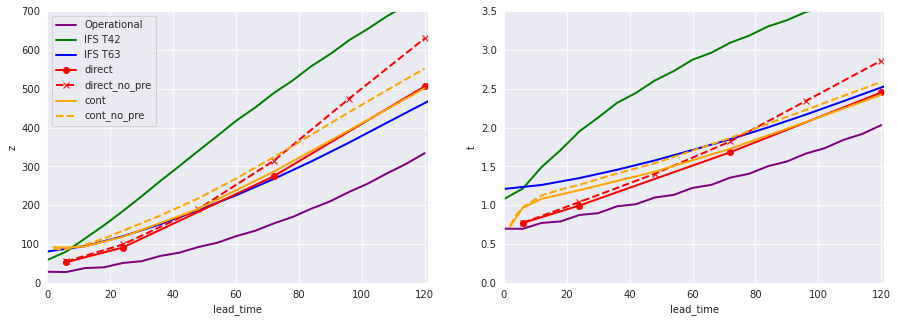

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_baseline['Operational'], 'Operational', c='purple')
plot_zt(rmse_baseline['IFS T42'], 'IFS T42', c='green')
plot_zt(rmse_baseline['IFS T63'], 'IFS T63', c='blue')
plot_zt(rmse_direct, 'direct', c='r', marker='o')
plot_zt(rmse_direct1, 'direct_no_pre', c='r', marker='x', ls='--')
plot_zt(rmse_cont, 'cont', c='orange')
plot_zt(rmse_cont1, 'cont_no_pre', c='orange', ls='--')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
ax1.set_ylim(0, 700)
ax2.set_ylim(0, 3.5)

## generalization error

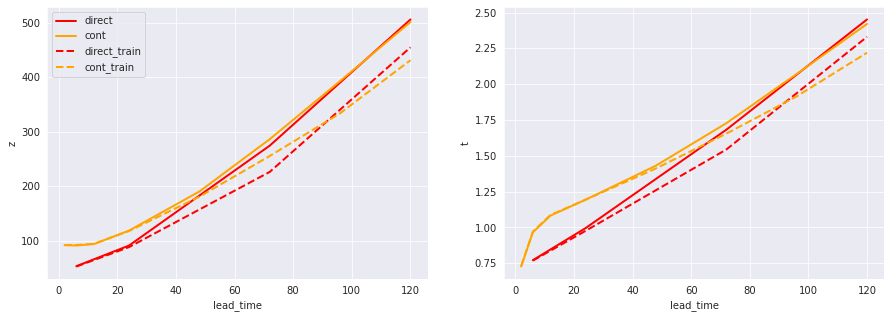

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_direct, 'direct', c='r')
plot_zt(rmse_cont, 'cont', c='orange')
plot_zt(rmse_direct_train, 'direct_train', c='r', ls='--')
plot_zt(rmse_cont_train, 'cont_train', c='orange', ls='--')
ax1.legend()

In [119]:
gen_direct = (rmse_direct - rmse_direct_train)
gen_cont = (rmse_cont - rmse_cont_train)

In [120]:
gen_direct_rel = (rmse_direct - rmse_direct_train) / (rmse_direct_train + rmse_direct) / 2
gen_cont_rel = (rmse_cont - rmse_cont_train) / (rmse_cont_train + rmse_cont) / 2

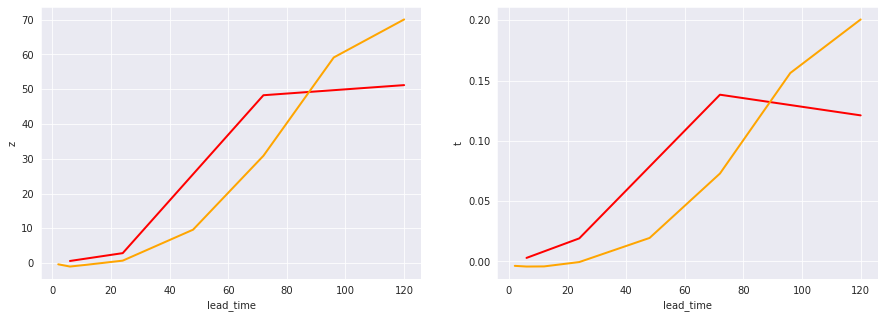

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(gen_direct, 'direct', c='r')
plot_zt(gen_cont, 'cont', c='orange')

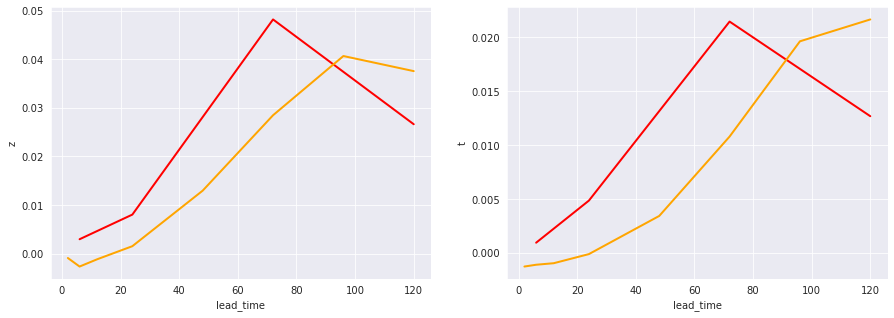

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(gen_direct_rel, 'direct', c='r')
plot_zt(gen_cont_rel, 'cont', c='orange')